# Introduction

This notebook solves the momentum and continuity equations for a 2D cross section of a Hookean solid block for one time step, where the displacement is rewritten in terms of velocity. Material properties of solid, geometry of cross section and the mesh is selected by the user.

## Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve


# Helper Functions

## Contour Plot

In [22]:
def contourPlot(Nx,Ny,Lx,Ly,value,valueName,unit):
    '''
    Creates a contour plot for 'value'
    Arguments:
        Lx, Ly: Dimensions of plate in x and y direction - unit: (m)
        Nx, Ny: Number of cells for mesh in x and y directions - no unit
        value: column vector of length M that represents a solution variable
        valueName: name for the value
        unit: unit for the value
    '''
    dx = Lx/Nx
    dy = Ly/Ny
    X,Y = np.meshgrid(np.arange(0,Lx,dx),np.arange(0,Ly,dy))#mesh grid for full mesh
    plot = np.reshape(value, (Ny, Nx))
    plt.figure()
    plt.contourf(X,Y,plot,cmap='inferno')
    plt.colorbar(label="%s %s"%(valueName,unit))
    plt.title("%s Distribution"%valueName, fontsize=15)
    plt.ylabel("Ly (m)")
    plt.xlabel("Lx (m)")

## Assemble Coefficient Matrix

In [23]:
def assemble_matrix(Nx,Ny,Lx,Ly,shear,rho,scaleFactor,dt):
    
    '''
    Builds the coefficient matrix (A) for the problem

    Arguments:
        Lx, Ly: Dimensions of plate in x and y direction - unit: (m)
        Nx, Ny: Number of cells for mesh in x and y directions - no unit
        shear: shear modulus of solid - unit: (Pa)
        rho: density of solid - unit: (kg/m^3)
        scaleFactor: scale factor for smoothing coefficient in Rhie-Chow term - no unit
        dt: time step - unit: (s)
    
    Returns:
        A: Coefficient matrix 
        b: Source vector 
        D: Smoothing coefficient
    '''
    
    '''
    Some helpful constants
    '''
    g = 9.81#gravity
    eqs = 3 #3 equations (momentum x, y and continuity)
    
    '''
    Mesh Info
    '''
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    M = int(Nx*Ny)
    
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    '''
    Coefficients
    '''
    #momentum equation
    #velocities
    ax = dt*shear*dy/dx
    ay = dt*shear*dx/dy

    ap = -2*(ax+ay)
    
    #CONTINUITY
    #velocities and pressure gradients momentum
    ex = dy/2
    ey = dx/2

    #smoothing term
    D = scaleFactor*dx*dy/(ap)
    #Implicit Pressure Gradient
    Sx = (D*dy)/dx
    Sy = (D*dx)/dy
    Sp = -2*(Sx+Sy)
    
    '''
    Initialisations
    '''
    #Initialise coefficient matrix
    A = np.zeros((eqs*M, eqs*M))
    #Initialise source vector
    b = np.zeros((eqs*M, 1))
    
    #CSR MATRIX
    internal = (Nx-2)*(Ny-2)
    corners = 4
    sides =  (2*Nx+2*Ny-8)
    numNonZeros = int(16*sides+4*14+23*internal) #16 by sides, 14 by corners, 23 by internals

    data = np.zeros((numNonZeros))
    row_idx = np.zeros((numNonZeros ))
    col_idx = np.zeros((numNonZeros ))
    
    '''
    Build Linear System (A and b)
    '''
    #Loop through each cell i
    coeffi=0
    for i in range(0, eqs*M, eqs):
        
        #CORNERS
        #bottom left
        if i == 0:
            #X-MOM

            #vpx
            data[coeffi] = ap-ax-ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            #Pp
            data[coeffi] = dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*g*dx*dy
            #LHS
            
            #vpy
            data[coeffi] = ap-ax-ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -dx
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = dx  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#
            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
        #bottom right
        elif i == botright:
            #X-MOM
            #-------#
    
            #vpx
            data[coeffi] = ap-ax-ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            #Pp
            data[coeffi] = -dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*g*dx*dy
            #LHS
            
            #vpy
            data[coeffi] = ap-ax-ay
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -dx
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = dx  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#
 
            #LHS
            
            #vpx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            
        #Top Left
        elif i == topleft:
            #X-MOM
            
            #vpx
            data[coeffi] = ap-ax-ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pp
            data[coeffi] = dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*g*dx*dy
            #LHS
            
            #vpy
            data[coeffi] = ap-ax-ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = dx
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -dx  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
     
            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
        #top right
        elif i == topright:
            #X-MOM

            #vpx
            data[coeffi] = ap-ax-ay 
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*g*dx*dy
            #LHS
            
            #vpy
            data[coeffi] = ap-ax-ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = dx
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -dx  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
       
        #SIDES
        #bottom
        elif 0 < i < botright:
            #X-MOM
            #-------#
            #vpx
            data[coeffi] = ap-ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*g*dx*dy
            #LHS
            #vpy
            data[coeffi] = ap-ay   
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -dx
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = dx  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
            #CONTINUITY
            #-------#

            #LHS
            
            #vpy
            data[coeffi] = ey 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
           
        #top
        elif topleft < i < topright:
            #X-MOM
      
            #vpx
            data[coeffi] = ap-ay   
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*g*dx*dy
            #LHS
            
            #vpy
            data[coeffi] =ap-ay 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = dx
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -dx  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):
            #X-MOM
            #-------#

             #vpx
            data[coeffi] = ap-ax   
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pp
            data[coeffi] = dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*dx*dy*g
            #LHS
            #vpy
            data[coeffi] = ap-ax   
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pn
            data[coeffi] = -ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
    
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):
            
            #X-MOM
           
            #LHS
            
            #vpx
            data[coeffi] =ap-ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -dy  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*g*dx*dy
            #LHS
            
            #vpy
            data[coeffi] = ap-ax   
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1

            
            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
        else:
            #X-MOM
            #-------#

            #vpx
            data[coeffi] = ap 
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = ex 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -ex 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = rho*dx*dy*g
            #LHS
            
            #vpy
            data[coeffi] = ap  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#

            #LHS
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #Pw
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Sy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Sp  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
      
    #compile coefficient matrix
    A = csr_matrix((data, (row_idx, col_idx)), shape=(eqs*M,eqs*M))
    
    return A,b,D
    

## Calculate Pressure Gradient of last iteration

In [24]:
def calculate_gradients(Nx,Ny,Lx,Ly,v):
    '''
    Calculates the pressure gradient at each cell centre explicitly for the last iteration to be used for momentum
    equation.
    
     Arguments:
        Lx, Ly: Dimensions of plate in x and y direction - unit: (m)
        Nx, Ny: Number of cells for mesh in x and y directions - no unit
        v: solution vector (u, v, p) of last iteration
    
    Returns:
        gradP: vector containing pressure gradient across each cell in x and y directions 
    '''
    
    '''
    Mesh Info
    '''
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    M = int(Nx*Ny)
    eqs = 3 #3 equations (momentum x, y and continuity)
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    
    '''
    Initialisation
    '''
    #initialise gradP vector (contains pressure gradient in x and y directions across each cell)
    gradP = np.zeros((2*M,1)) 
    
    '''
    Loop through all cells
    '''
    #Loop through each cell i
    for i,coeff in zip(range(0, eqs*M, eqs),range(0,2*M,2)):#i in steps of 3 (solution vector) and coeff in steps
                                                            #of 2 (gradP vector)
        #CORNERS
        #bottom left
        if i == 0:
            
            gradP[coeff]  =(v[i+5]-v[i+2])/dx # (PE-PP)/dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/dy # (PN-PP)/dy
                        
        #bottom right
        elif i == botright:
                        
            gradP[coeff] = (v[i+2]-v[i-1])/dx # (PP-PW)/dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/dy # (PN-PP)/dy
            
        #top left
        elif i == topleft:
            gradP[coeff]  = (v[i+5]-v[i+2])/dx # (PE-PP)/dx
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/dy #((PP-PS)/dy
            
        #top right
        elif i == topright:
            
            gradP[coeff] = (v[i+2]-v[i-1])/dx # (PP-PW)/dx
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/dy #((PP-PS)/dy
             
        #SIDES
        #bottom
        elif 0 < i < botright:
            
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/dy # (PN-PP)/dy
            
        #top
        elif topleft < i < topright:
                        
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/dy #(PP-PS)/dy

        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):
           
            gradP[coeff]  = (v[i+5]-v[i+2])/dx # (PE-PP)/dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
            
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):
            
            gradP[coeff] = (v[i+2]-v[i-1])/dx # (PP-PW)/dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
        #internal  
        else:
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
    return gradP

# Main Simulation


In [28]:
def SolidBlockUnderGravity(Lx,Ly,Nx,Ny,shear,rho,scaleFactor,dt,max_its,tol):
    '''
    Solves the steady-state continuity and momentum equations using the finite volume method with a coupled solver
    approach for a Hookean solid.

    Arguments:
        Lx, Ly: Dimensions of plate in x and y direction - unit: (m)
        Nx, Ny: Number of cells for mesh in x and y directions - no unit
        shear: shear modulus of solid - unit: (Pa)
        rho: density of solid - unit: (kg/m^3)
        scaleFactor: scale factor for smoothing coefficient in Rhie-Chow term - no unit
        max_its: maximum number of iterations to solve equations at each time step - no unit
        tol: tolerance to determine if solution is converged - no unit
    
    Returns:
        dispx: displacment x direction at each cell centre - unit: (m)
        dispy: velocity y direction at each cell centre - unit: (m)
        p: pressure at each cell centre - unit: (Pa)
        dispmag: displacment magnitude at each cell centre - unit: (m)
    '''
    
    '''
    Mesh Info
    '''
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    
    # total number of cells
    M = int(Nx*Ny)
    #equations being solved
    eqs = 3
     #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    #assemble matrix A
    A,b,D = assemble_matrix(Nx,Ny,Lx,Ly,shear,rho,scaleFactor,dt)
    
    '''
    Coefficients
    '''
    #presure momentum and continuity velocities
    ex = dy/2
    ey = dx/2
    
    #Explicit Pressure Gradient
    Rx = (D*dy)/2
    Ry = (D*dx)/2
    
    #Implicit Pressure Gradient
    Sx = (D*dy)/dx
    Sy = (D*dx)/dy
    Sp = -2*(Sx+Sy)
    
    
    
    '''
    Initialisation
    '''
    #Solution vector
    v = np.zeros((eqs*M, 1)) #results vector old iteration
    vnew = np.zeros((eqs*M,1)) #results vector new iteration
    
    #displacements
    dispx = np.zeros((M,1))  #displacements x
    dispy = np.zeros((M,1)) #displacements y
    dispxold = np.zeros((M,1))  #displacements x last time step
    dispyold = np.zeros((M,1)) #displacements y last time step
    
    #velocities and pressures
    vx = np.zeros((M, 1))#velocity x old
    vxnew = np.zeros((M, 1)) #velocity x new
    vy = np.zeros((M, 1))#velocity y old
    vynew = np.zeros((M, 1)) #velocity y new
    p = np.zeros((M, 1)) #pressure
    pnew = np.zeros((M, 1)) #pressure new
    
    #list of residuals for each unknown
    residualsvx = []
    residualsvy = []
    residualsp = []
    init_resvx = 1
    init_resvy = 1
    init_resp = 1
    
    '''
    Solve momentum and continuity equations
    '''
    print('Iterations, Residual vx, Residual vy, Residual p')
    
    for iterations in range(1,max_its+1): #run for a maximum of 'max_its' iterations
        
        #calculate gradP for new iteration
        gradP = calculate_gradients(Nx,Ny,Lx,Ly,v)

        for i,coeff in zip(range(0, eqs*M, eqs),range(0,2*M,2)):
            #CORNERS
            #bottom left
            if i == 0:
                continue
                
            #bottom right
            elif i == botright:
                continue
            elif i == topleft:
                
                continue
            #top right
            elif i == topright:
                continue
            #SIDES
            #bottom
            elif 0 < i < botright:
                
                continue
            #top
            elif topleft < i < topright:
                 
                continue
            #left / Inlet
            elif i in range(eqs*Nx,topleft,eqs*Nx):
                
                continue
            #right / Outlet
            elif i in range(botright+eqs*Nx,topright,eqs*Nx):
                
                continue
            #internal
            else:
                #re*dPe-rw*dPw+rn*dPn-rs*dPs
                b[i+2] = gradP[coeff+2]*Rx-gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry-gradP[coeff-2*Nx+1]*Ry
        
        '''
        Solve
        '''
        vnew = scipy.sparse.linalg.spsolve(A,b)
    
        #get components of solution vector
        vxnew = vnew[0::3].reshape(M,1) #vx component
        vynew = vnew[1::3].reshape(M,1) #vy component
        pnew = vnew[2::3].reshape(M,1) #pressure component
        
        #stop pressure drifting - enforce symmetry
        pnew = pnew-np.mean(pnew)
        
        #calculate residuals
        resvx = np.linalg.norm(vxnew-vx)/init_resvx
        resvy = np.linalg.norm(vynew-vy)/init_resvy
        resp = np.linalg.norm(pnew-p)/init_resp
        
        #set initial resdiual if first iteration
        if (iterations==1):
            # Use a small number if the initial residual is small
            init_resvx = max(resvx, 1e-12)
            init_resvy = max(resvy, 1e-12)
            init_resp = max(resp, 1e-12)
            resvx = 1
            resvy = 1
            resp = 1
        
        #update solution
        vx = vxnew
        vy = vynew
        
        p = pnew
        v = vnew
        
        #update displacements
        dispx = dispxold+ vx*dt
        dispy = dispyold+vy*dt
        
        #print residuals
        print(iterations, resvx, resvy, resp, '\n')
        
        #Break loop if tolerance reached
        if (resvy<tol and resp<tol and resvx<tol):
            print("tolerance reached in %i iterations"%(iterations))
            break
        elif (iterations == (max_its)):#if last iteration
            print("max iterations reached!")
    '''
    Results
    '''
    #end of time step update old values
    dispxold = dispx
    dispyold = dispy

    #get displacment and velocity magnitude
    disp = (np.sqrt(np.square(dispx.reshape(M,1))+np.square(dispy.reshape(M,1))))
    vmag = (np.sqrt(np.square(vx)+np.square(vy)))
    
    contourPlot(Nx,Ny,Lx,Ly,disp,'Displacement Magnitude', 'm')
    contourPlot(Nx,Ny,Lx,Ly,p,'Pressure', 'Pa')
    
    print('max pressure',np.max(p))
    print('min pressure',np.min(p))
    return dispx,dispy,p,disp

In [31]:
#Geometry
Lx = 1 #length x direction
Ly = 1 #length y direction

#Mesh
Nx = 100
Ny = 100

#Material properties
shear = 1e6 #shear modulus
rho = 1102 #solid density

#other parameters
scaleFactor = 1
max_its = 10
tol = 1e-6
dt = 1

#### Run Simulation

Iterations, Residual vx, Residual vy, Residual p
1 1 1 1 

2 1.0161418881013058 0.9014823354425532 4.7551367038956555e-08 

3 0.7538607711366412 0.733773939475569 3.532899303705879e-08 

4 0.5458329554609946 0.5126530671824663 1.922758892817141e-08 

5 0.7525390423537721 0.5823671811755906 2.726797384122306e-08 

6 1.0485616216799576 0.8784916668548194 3.3330649575142663e-08 

7 1.0725959562640865 0.6002120847398255 3.843345977056458e-08 

8 1.3016707899551678 0.8009471023355021 5.1233431422145e-08 

9 0.9690632101780726 0.6421920417787712 3.399095824558122e-08 

10 0.6424572526844139 0.6197941410208885 1.8368351577085945e-08 

max iterations reached!
max pressure 5351.257586569823
min pressure -5351.2578838807485


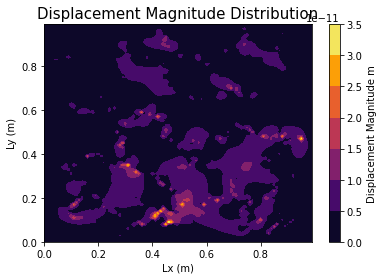

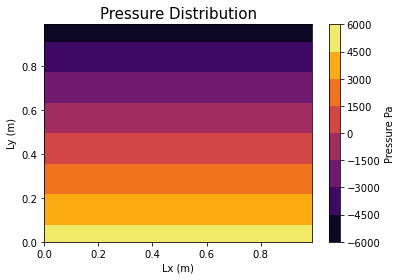

In [32]:
dispx,dispy,p,disp = SolidBlockUnderGravity(Lx,Ly,Nx,Ny,shear,rho,scaleFactor,dt,max_its,tol)